In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import accuracy
import torch
import torch.nn as nn
from fastai.callbacks.hooks import *

In [3]:
PATH = "/project/DSone/as3ek/data/patches/1000/gannorm_seem_cinn_256/"
sz = 256
tfms = get_transforms(do_flip=True, flip_vert=True, max_zoom=1.1)

In [4]:
data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, size=sz)
mean_std = data.batch_stats()
data.normalize(mean_std)

ImageDataBunch;

Train: LabelList (82100 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Normal,Normal,Normal,Normal,Normal
Path: /project/DSone/as3ek/data/patches/1000/gannorm_seem_cinn_256;

Valid: LabelList (28993 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Normal,Normal,Normal,Normal,Normal
Path: /project/DSone/as3ek/data/patches/1000/gannorm_seem_cinn_256;

Test: None

In [5]:
learn = cnn_learner(data, models.resnet101, metrics=accuracy)

In [ ]:
# device_ids = list(range(torch.cuda.device_count()))
# learn.model = nn.DataParallel(learn.model, device_ids=device_ids)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


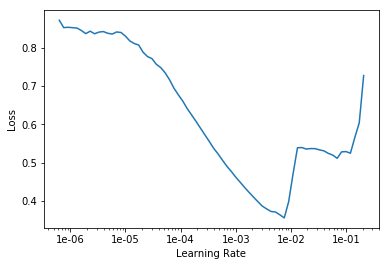

In [7]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [6]:
learn.fit_one_cycle(1, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.003297,0.001489,0.999586,40:11


In [7]:
learn.save('unfreeze101-epoch-1-meanstdnorm')

In [8]:
learn.load('unfreeze101-epoch-1-meanstdnorm')

Learner(data=ImageDataBunch;

Train: LabelList (82100 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Normal,Normal,Normal,Normal,Normal
Path: /project/DSone/as3ek/data/patches/1000/gannorm_seem_cinn_256;

Valid: LabelList (28993 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Normal,Normal,Normal,Normal,Normal
Path: /project/DSone/as3ek/data/patches/1000/gannorm_seem_cinn_256;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), 

In [25]:
data.one_batch()[0].size()

torch.Size([32, 3, 256, 256])

In [21]:
a.stored

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

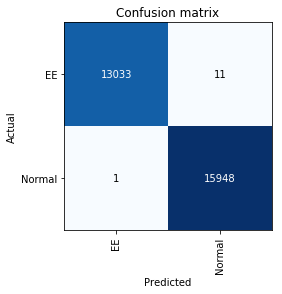

In [10]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(81, figsize=(30, 30))

In [ ]:
interp.plot_top_losses(81, figsize=(30, 30), heatmap=True)

In [ ]:
interp.plot_top_losses(81, largest=False, figsize=(30, 30))

In [ ]:
interp.plot_top_losses(81, largest=False, figsize=(30, 30), heatmap=True)

In [9]:
def show_heatmap(interp, index, label='', save=False, savepath=False):
    hm = interp.GradCAM(index, image=False)
    xb_im = interp.ds.x[index]
    _,ax = plt.subplots(1, 2, figsize=(15, 15))
    
    xb_im.show(ax[0])
    xb_im.show(ax[1])
    ax[1].imshow(hm, alpha=0.6, extent=(0,256,256,0),
              interpolation='bilinear', cmap='magma')
    _.suptitle(label)
    if save:
        if savepath:
            _.savefig(savepath)
            plt.close(_)
        else:
            return 'Please give savepath'

In [ ]:
preds = interp.preds.detach().cpu().numpy()
base_path = '/scratch/as3ek/misc/'
for index, row in interp.ds.to_df().iterrows():
    pred_normal = round(preds[index][1], 4)
    pred_ee = round(preds[index][0], 4)
    actual = str(row['x']).split('/')[1]
    name = str(row['x']).split('/')[2].split('.')[0]
    
    if pred_normal > pred_ee:
        prediction = 'Normal'
        probab = pred_normal
    else:
        prediction = 'EE'
        probab = pred_ee
        
    label = 'Name: ' + name + ' | Actual: ' + actual + ' | Prediction: ' + prediction + ' | Probability: ' + str(probab*100)
    if actual == prediction:
        savepath = base_path + 'correct_classification/'
    else:
        savepath = base_path + 'incorrect_classification/'
    
    savepath = savepath + str(row['x']).replace('valid/', '')
    if not os.path.exists(('/').join(savepath.split('/')[:-1])):
        os.makedirs(('/').join(savepath.split('/')[:-1]))

    show_heatmap(interp, index, label, save=True, savepath=savepath)

In [12]:
('/').join(savepath.split('/')[:-1])

'/scratch/as3ek/misc/correct_classification/EE'

In [19]:
a = interp.ds.to_df()

In [35]:
a['probab_ee'] = interp.preds.detach().cpu().numpy()[:, 0]

In [36]:
a['probab_normal'] = interp.preds.detach().cpu().numpy()[:, 1]

In [49]:
a['prediction'] = np.where(a['probab_ee'] > a['probab_normal'], 'EE', 'Normal')

In [51]:
a.to_csv('test_set_seem_iteration2.csv', index=False)